In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

In [2]:
ngram_to_kendal_vals = {
    2: [1, 2, 3, 4, 5, 6, 7, 8, 9],
    5: [1, 2, 3, 4, 5, 6, 7, 8, 9],
    10: [2, 3, 4, 5, 6, 7, 8],
}

In [3]:
def compute_rho(phi_fuz: float, phi_exact: dict, n_extrapol_large=3):
    '''
    n_extrapol_large: the number of largest exact duplicates to use for extrapolation beyond max
                      if 1, this can be quite sensitive to noise, so default is 3
    '''

    lambda_ = None
    max_key = max(phi_exact.keys())
    
    # first if the target is smaller than the smallest for exact
    if phi_fuz <= phi_exact[1]:
        lambda_ = 1
        neq = lambda_ + (phi_fuz - phi_exact[lambda_]) / (phi_exact[lambda_+1] - phi_exact[lambda_])
        neq = max(1.0, neq)
    
    # then if the target is larger than the largest for exact, extrapolate
    elif phi_fuz >= phi_exact[max_key]:
        
        n0 = max_key - n_extrapol_large
        slope = np.mean([np.abs(phi_exact[i + 1] - phi_exact[i]) for i in range(n0, max_key)])
        neq = max_key + (phi_fuz - phi_exact[max_key]) / slope 
        
        #lambda_ = max_key
        #neq = lambda_ + (phi_fuz - phi_exact[lambda_]) / (phi_exact[lambda_] - phi_exact[lambda_ - 1])
    
    # do interpolation otherwise
    else:
        for n in range(1, max_key):
            if phi_exact[n] <= phi_fuz and phi_exact[n+1] >= phi_fuz:
                lambda_ = n
        neq = lambda_ + (phi_fuz - phi_exact[lambda_]) / (phi_exact[lambda_ + 1] - phi_exact[lambda_])
    
    # return the normalized value (assuming n_dup=10)
    return (neq - 1) / 9.0
  
def smooth_curve(nrep_aucs, mia = 'ratio', window_size=3):
    
    original_values =  [np.mean(nrep_aucs[n][mia]) for n in range(1, max(nrep_aucs.keys()) + 1)]

    # Apply a moving average with a window of 3
    smoothed_values = np.convolve(original_values, np.ones(window_size) / window_size, mode='valid')

    # Extend smoothed values to match original length
    smoothed_values = np.concatenate(([original_values[0]], smoothed_values, [original_values[-1]]))
        
    return {n:smoothed_values[i] for i, n in enumerate(range(1,max(nrep_aucs.keys())+1))}

In [ ]:
# get the scrambled baseline

all_ns = (2,5, 10)

all_rhos_baseline = {n:[] for n in all_ns}

seeds = (1, 2, 3, 4, 5)
mia='ratio'

for seed in seeds:
    exact_path = f"SOME_DATA_DIR/nrep_aucs_gptneo1B_exactduplicates_seed{seed}_lr2e5.pickle"
     
    with open(exact_path, "rb") as f:
        nrep_aucs = pickle.load(f)
        
    all_phi_exact = smooth_curve(nrep_aucs, mia=mia, window_size=3)
    
    # load the insertion results
    insert_path = f"SOME_DATA_DIR/results_n_gram_scrambled_gptneo1B_seed{seed}_lr2e5.pickle"
    
    with open(insert_path, "rb") as f:
        all_scramble_results = pickle.load(f)
        
    for n in all_ns:
        all_rhos_baseline[n].append(compute_rho(phi_fuz=all_scramble_results[n][mia], phi_exact=all_phi_exact))
    
all_rhos_baseline

{2: [np.float64(0.09258547829427603),
  np.float64(0.11430855315747415),
  np.float64(0.08467227748023465),
  np.float64(0.09253768223375336),
  np.float64(0.10137519776073993)],
 5: [np.float64(0.1813126799721976),
  np.float64(0.1982414068745007),
  np.float64(0.19443063152660361),
  np.float64(0.16410693970420953),
  np.float64(0.1885788328937018)],
 10: [np.float64(0.3367045063639489),
  np.float64(0.315995950392306),
  np.float64(0.31703703703703684),
  np.float64(0.2891480401684485),
  np.float64(0.28695275249241486)]}

n=2, tau=1: mean rho=0.5264 +/- 0.0259
n=2, tau=2: mean rho=0.3462 +/- 0.0101
n=2, tau=3: mean rho=0.2398 +/- 0.0175
n=2, tau=4: mean rho=0.1811 +/- 0.0067
n=2, tau=5: mean rho=0.1740 +/- 0.0122
n=2, tau=6: mean rho=0.1656 +/- 0.0093
n=2, tau=7: mean rho=0.1711 +/- 0.0063
n=2, tau=8: mean rho=0.1631 +/- 0.0075
n=2, tau=9: mean rho=0.1616 +/- 0.0104
n=5, tau=1: mean rho=0.6425 +/- 0.0432
n=5, tau=2: mean rho=0.5014 +/- 0.0416
n=5, tau=3: mean rho=0.3856 +/- 0.0179
n=5, tau=4: mean rho=0.3336 +/- 0.0321
n=5, tau=5: mean rho=0.3024 +/- 0.0093
n=5, tau=6: mean rho=0.2943 +/- 0.0168
n=5, tau=7: mean rho=0.2934 +/- 0.0082
n=5, tau=8: mean rho=0.2853 +/- 0.0107
n=5, tau=9: mean rho=0.2772 +/- 0.0230
n=10, tau=2: mean rho=0.5673 +/- 0.0349
n=10, tau=3: mean rho=0.5366 +/- 0.0478
n=10, tau=4: mean rho=0.4667 +/- 0.0495
n=10, tau=5: mean rho=0.4394 +/- 0.0135
n=10, tau=6: mean rho=0.4112 +/- 0.0262
n=10, tau=7: mean rho=0.4111 +/- 0.0162
n=10, tau=8: mean rho=0.3925 +/- 0.0123


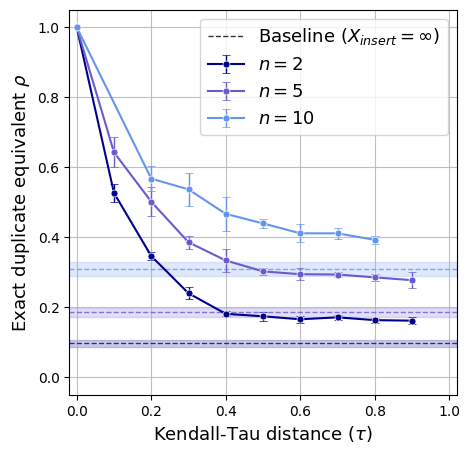

In [ ]:
mia = 'ratio'
colors = ['darkblue', 'slateblue', 'cornflowerblue'] # , 

n_to_seeds = {
    2: [1, 2, 3, 4, 5],
    5: [1, 2, 3, 4, 5],
    10: [1, 2, 3, 4, 5],
}
    

plt.figure(figsize = (5, 5))

for i, ngram in enumerate(all_ns):
    
    kendall_values = ngram_to_kendal_vals[ngram]
    
    all_rhos = {tau:[] for tau in kendall_values}
    
    for seed in n_to_seeds[ngram]:
        
        exact_path = f"SOME_DATA_DIR/nrep_aucs_gptneo1B_exactduplicates_seed{seed}_lr2e5.pickle"
         
        with open(exact_path, "rb") as f:
            nrep_aucs = pickle.load(f)
            
        all_phi_exact = smooth_curve(nrep_aucs, mia=mia, window_size=3)
        
        # load the shuffle results
        shuffle_path = f"SOME_DATA_DIR/results_n_gram_shuffle_gptneo1B_seed{seed}_n{ngram}_lr2e5.pickle"
        
        with open(shuffle_path, "rb") as f:
            all_shuffle_results = pickle.load(f)
            
        for tau in kendall_values:
            all_rhos[tau].append(compute_rho(phi_fuz=all_shuffle_results[tau][mia], phi_exact=all_phi_exact))
            
    mean_rhos = [np.mean(all_rhos[tau]) for tau in kendall_values]
    std_rhos = [np.std(all_rhos[tau]) for tau in kendall_values]
    
    for tau in kendall_values:
        print(f"n={ngram}, tau={tau}: mean rho={np.mean(all_rhos[tau]):.4f} +/- {np.std(all_rhos[tau]):.4f}")
    
    key = f'ngram{ngram}_kendall%d'
    
    plt.errorbar([0] + kendall_values, 
             [1] + mean_rhos,
             yerr=[0] + std_rhos,
             fmt='-o', 
             color=colors[i], 
             markersize=5,
             markeredgecolor='white', 
             markerfacecolor=colors[i], 
             markeredgewidth=0.5,
             capsize=3,  # adds caps to error bars
             capthick=1,
             elinewidth=1,
             label=rf"$n={ngram}$")

    # get the baseline too as a horizontal line
    plt.axhline(y=np.mean(all_rhos_baseline[ngram]), color=colors[i], linestyle='--', alpha=0.8, linewidth=1)
    # also do fill between for the std
    plt.fill_between([-.2, 10.2], 
                     np.mean(all_rhos_baseline[ngram]) - np.std(all_rhos_baseline[ngram]), 
                     np.mean(all_rhos_baseline[ngram]) + np.std(all_rhos_baseline[ngram]), 
                     color=colors[i], alpha=0.2)
    
# add the legend for baseline
plt.axhline(y=2.0, color='black', linestyle='--', alpha=0.8, linewidth=1, label = f"Baseline ($X_{{insert}}=\infty$)")

plt.xlabel(r'Kendall-Tau distance ($\tau$)', fontsize = 13)
plt.ylabel(r"Exact duplicate equivalent $\rho$", fontsize = 13)
plt.legend(loc='upper right', fontsize=13)
plt.xticks([0, 2, 4, 6, 8, 10], [0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.grid(alpha = 0.8, which='both', axis='both')
plt.xlim(-0.2, 10.2)
plt.ylim(-0.05, 1.05)
plt.show()